Towards Graph Machine Learning

In [2]:
import numpy as np
import networkx as nx

In [3]:
G = nx.karate_club_graph()

In [4]:
nx.info(G)

'Graph named "Zachary\'s Karate Club" with 34 nodes and 78 edges'

In [5]:
key_to_num = {'Mr. Hi':0, 'Officer':1}

In [6]:
labels = {}
for key,data in G.nodes(data=True):
  labels[key] = key_to_num[data['club']]

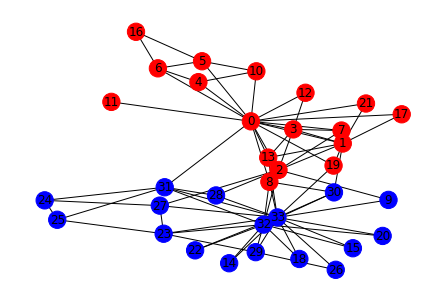

In [7]:
colors = ['blue' if labels[key] else 'red' for key in labels]
nx.draw(G, node_color=colors, with_labels=True)

Node classification using shallow feature extraction

In [8]:
degrees = [d for _, d in G.degree()]
centrality = [nx.degree_centrality(G)[n] for n in G]

features = np.array(centrality).reshape(-1, 1) #Nx1
targets = list(labels.values())

print(features.shape)
len(targets)

(34, 1)


34

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=.5, stratify=targets)

In [10]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(X_train, y_train)

In [11]:
reg.predict(X_test)

array([0.50995685, 0.3471623 , 0.50995685, 0.47378029, 0.52804514,
       0.52804514, 0.52804514, 0.47378029, 0.49186857, 0.455692  ,
       0.49186857, 0.40142715, 0.52804514, 0.52804514, 0.49186857,
       0.54613342, 0.52804514])

In [13]:
y_pred = np.int32(reg.predict(X_test) > 0.5)

In [14]:
sum(y_pred == y_test) / len(y_pred)

0.4117647058823529

Node classification using HOPE

In [15]:
%%capture
!pip install git+https://github.com/palash1992/GEM.git

In [16]:
from gem.embedding.hope import HOPE
hp = HOPE(d=4, beta=0.01)
hp.learn_embedding(G);

SVD error (low rank): 0.091151


In [ ]:
hp.get_embedding()

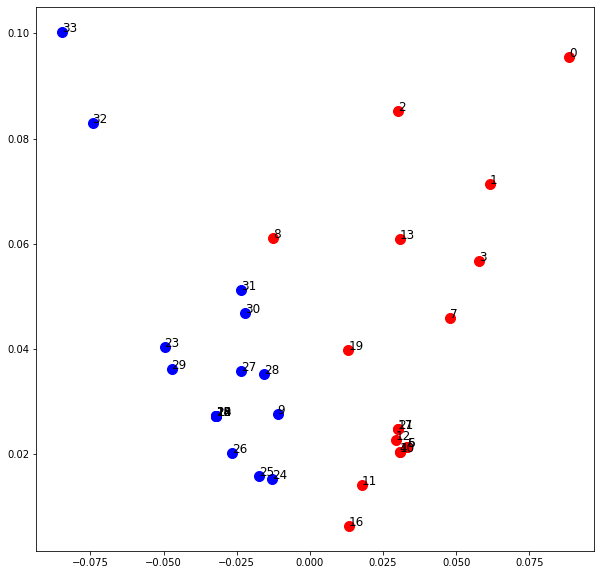

In [18]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10,10))

for i,x in enumerate(G.nodes()):
  v = hp.get_embedding()[i]
  ax.scatter(v[0],v[1], s=100, c=colors[i])
  ax.annotate(str(x), (v[0],v[1]), fontsize=12)

In [19]:
from sklearn.cluster import KMeans

In [20]:
embeddings = np.array([hp.get_embedding()[i] for i in range(G.number_of_nodes())]).reshape(-1, 4)
y_pred = KMeans(n_clusters=2, random_state=0).fit_predict(embeddings)

In [21]:
sum(y_pred == targets) / len(targets)

0.029411764705882353

Unsupervised Node classification with Node2Vec

In [22]:
%%capture
!pip install node2vec

In [23]:
from node2vec import Node2Vec

node2vec = Node2Vec(G, dimensions=2)
model = node2vec.fit(window=3)

Computing transition probabilities:   0%|          | 0/34 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:01<00:00,  8.56it/s]


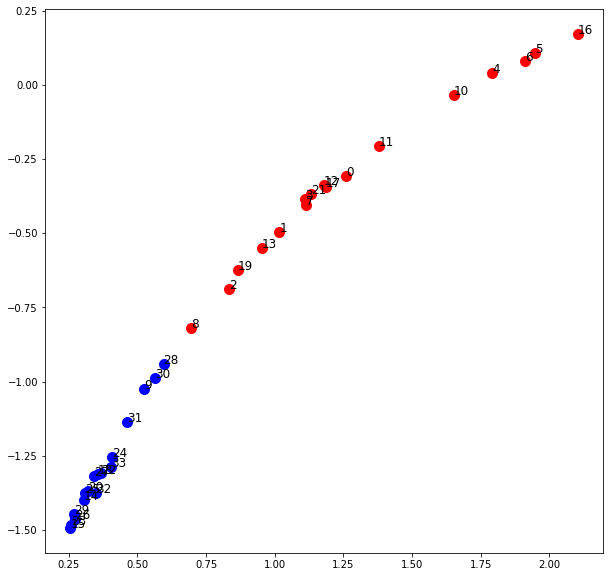

In [24]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10,10))

for i,x in enumerate(G.nodes()):
  v = model.wv[str(x)]
  ax.scatter(v[0],v[1], s=100, c=colors[i])
  ax.annotate(str(x), (v[0],v[1]), fontsize=12)

plt.show()

In [ ]:
embeddings = np.array([model.wv[str(x)] for x in G.nodes()]).reshape(-1, 2)
y_pred = KMeans(n_clusters=2, random_state=0).fit_predict(embeddings)

In [ ]:
sum(y_pred == targets) / len(targets)

## Graph Neural Networks

Spectral graph convolution

In [26]:
import numpy as np
from scipy.sparse.linalg import eigsh

In [29]:
A = nx.to_numpy_matrix(G)
#A = np.int32(A > 0)

$X^{l+1} = V(V^TX^{l} * V^TW_{spectral}^{l})$

In [30]:
num_nodes = A.shape[0]

# Compute the degree vector
D = np.sum(A, axis = 1)

# Invert the square root of the degree
D_hat = np.eye(num_nodes)
np.fill_diagonal(D_hat, D)

# Return the Normalized Adjacency
L = D_hat - A # Laplacian

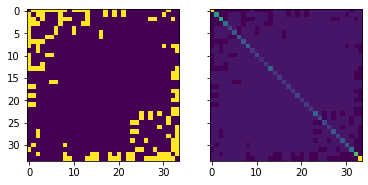

In [31]:
import matplotlib.pyplot as plt

fig,(ax1,ax2) = plt.subplots(1,2,sharey=True)

ax1.imshow(A)
ax2.imshow(L)
plt.show()

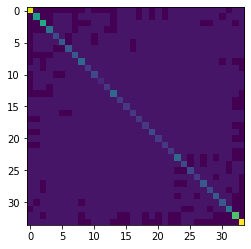

In [32]:
L_nx = nx.laplacian_matrix(G).todense()
fig,ax = plt.subplots(1,1)
ax.imshow(L_nx)
plt.show()

In [34]:
# To compute spectral graph convolution in practice, it’s enough to use a few eigenvectors ('SM')
# http://blog.shriphani.com/2015/04/06/the-smallest-eigenvalues-of-a-graph-laplacian/
# https://medium.com/analytics-vidhya/eigen-vectors-and-eigen-values-of-graph-laplacian-and-fourier-basis-b1517cc3250
vecs, vals = eigsh(L, k=20, which='SM')

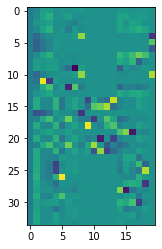

In [35]:
# visualize eigenvecs and eigenvals
fig,ax = plt.subplots(1,1,sharey=True)
ax.imshow(vals)
plt.show()

In [36]:
W_spectral = np.random.rand(num_nodes, 2) # NxF
X = np.random.rand(num_nodes,1) #Nx1

X_hat = vals.T.dot(X)
print("X_hat shape:", X_hat.shape)
W_hat = vals.T.dot(W_spectral)
print("W_hat shape:", W_hat.shape)

Y = vals.dot(np.multiply(X_hat,W_hat))
print("Y shape", Y.shape)

X_hat shape: (20, 1)
W_hat shape: (20, 2)
Y shape (34, 2)


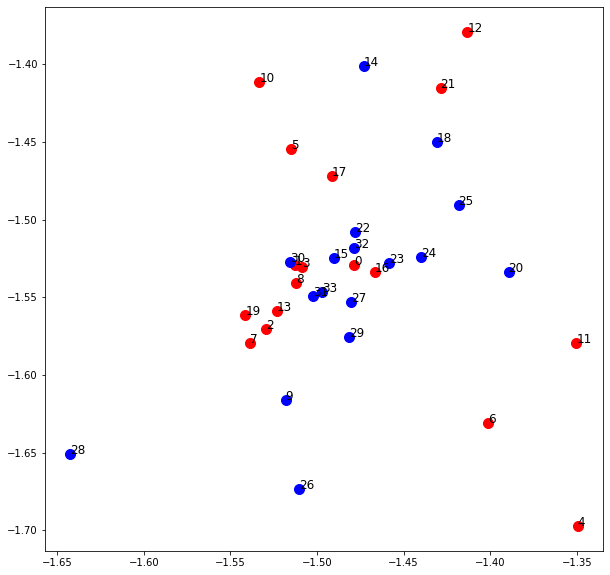

In [37]:
fig, ax = plt.subplots(figsize=(10,10))

for i,x in enumerate(G.nodes()):
  v = Y[i]
  ax.scatter(v[0],v[1], s=100, c=colors[i])
  ax.annotate(str(x), (v[0],v[1]), fontsize=12)

plt.show()

[Graph Convolution](https://tkipf.github.io/graph-convolutional-networks/) (Kipf and Welling)

$\hat{D}^{-\frac{1}{2}}\hat{A}\hat{D}^{-\frac{1}{2}}XW$

In [38]:
num_nodes = A.shape[0]

# sum the identity to take into account self nodes
A_hat = A + np.eye(num_nodes)

# Compute the degree vector
D = np.sum(A, axis = 1)

# Invert the square root of the degree
D_hat = np.eye(num_nodes)
np.fill_diagonal(D_hat, D)

D_hat = (D_hat + 1e-5) ** (-1/2)

# Return the Normalized Adjacency
L = D_hat @ A_hat @ D_hat # Laplacian

In [39]:
W = [np.random.rand(num_nodes, num_nodes), np.random.rand(num_nodes, num_nodes), np.random.rand(num_nodes, 2)]
X = np.eye(num_nodes)

for i in range(3):
  Y = L @ X @ W[i]
  X = Y

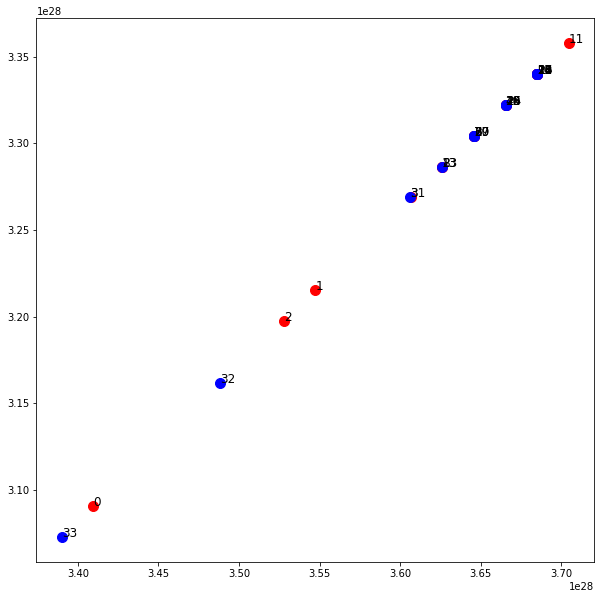

In [40]:
fig, ax = plt.subplots(figsize=(10,10))

for i,x in enumerate(G.nodes()):
  v = Y[i]
  ax.scatter(v[0,0],v[0,1], s=100, c=colors[i])
  ax.annotate(str(x), (v[0,0],v[0,1]), fontsize=12)

plt.show()

## Graph Neural Network in (quasi) real life

In [41]:
%%capture
!pip install stellargraph
!pip install -U networkx

In [42]:
import pandas as pd
import os

import stellargraph as sg
from stellargraph.mapper import FullBatchNodeGenerator
from stellargraph.layer import GCN

from tensorflow.keras import layers, optimizers, losses, metrics, Model
from sklearn import preprocessing, model_selection
from IPython.display import display, HTML
import matplotlib.pyplot as plt
%matplotlib inline

In [43]:
dataset = sg.datasets.Cora()
display(HTML(dataset.description))
G, node_subjects = dataset.load()

In [44]:
print(G.info())

StellarGraph: Undirected multigraph
 Nodes: 2708, Edges: 5429

 Node types:
  paper: [2708]
    Features: float32 vector, length 1433
    Edge types: paper-cites->paper

 Edge types:
    paper-cites->paper: [5429]
        Weights: all 1 (default)
        Features: none


In [45]:
node_subjects.value_counts().to_frame()

,subject
Neural_Networks,818
Probabilistic_Methods,426
Genetic_Algorithms,418
Theory,351
Case_Based,298
Reinforcement_Learning,217
Rule_Learning,180


In [46]:
train_subjects, test_subjects = model_selection.train_test_split(
    node_subjects, train_size=140, test_size=None, stratify=node_subjects
)
val_subjects, test_subjects = model_selection.train_test_split(
    test_subjects, train_size=500, test_size=None, stratify=test_subjects
)

In [47]:
train_subjects.value_counts().to_frame()

,subject
Neural_Networks,42
Genetic_Algorithms,22
Probabilistic_Methods,22
Theory,18
Case_Based,16
Reinforcement_Learning,11
Rule_Learning,9


In [48]:
target_encoding = preprocessing.LabelBinarizer()

train_targets = target_encoding.fit_transform(train_subjects)
val_targets = target_encoding.transform(val_subjects)

In [49]:
generator = FullBatchNodeGenerator(G, method="gcn")

Using GCN (local pooling) filters...


In [50]:
train_gen = generator.flow(train_subjects.index, train_targets)
val_gen = generator.flow(val_subjects.index, val_targets)

In [51]:
gcn = GCN(layer_sizes=[16, 16], activations=["relu", "relu"], generator=generator, dropout=0.5)
x_inp, x_out = gcn.in_out_tensors()

In [53]:
predictions = layers.Dense(units=train_targets.shape[1], activation="softmax")(x_out)

In [54]:
model = Model(inputs=x_inp, outputs=predictions)
model.compile(
    optimizer=optimizers.Adam(learning_rate=0.01),
    loss=losses.categorical_crossentropy,
    metrics=["acc"],
)

In [ ]:
history = model.fit(
    train_gen,
    epochs=200,
    validation_data=val_gen,
    verbose=2,
    shuffle=False,  # this should be False, since shuffling data means shuffling the whole graph
)

In [56]:
all_nodes = node_subjects.index
all_gen = generator.flow(all_nodes)
all_predictions = model.predict(all_gen)

In [57]:
embedding_model = Model(inputs=x_inp, outputs=x_out)

In [59]:
emb = embedding_model.predict(all_gen)
emb.shape

(1, 2708, 16)

In [60]:
from sklearn.manifold import TSNE
transform = TSNE  # or PCA

In [61]:
X = emb.squeeze(0)

trans = transform(n_components=2)
X_reduced = trans.fit_transform(X)
X_reduced.shape

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


(2708, 2)

[Text(0, 0.5, '$X_2$'),
 Text(0.5, 0, '$X_1$'),
 Text(0.5, 1.0, 'TSNE visualization of GCN embeddings for cora dataset'),
 None]

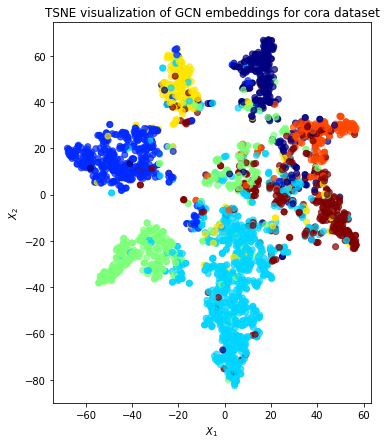

In [62]:
fig, ax = plt.subplots(figsize=(7, 7))
ax.scatter(
    X_reduced[:, 0],
    X_reduced[:, 1],
    c=node_subjects.astype("category").cat.codes,
    cmap="jet",
    alpha=0.7,
)
ax.set(
    aspect="equal",
    xlabel="$X_1$",
    ylabel="$X_2$",
    title=f"{transform.__name__} visualization of GCN embeddings for cora dataset",
)

Let's try to slightly vary the task and perform link prediction!

In [ ]:
import stellargraph as sg
from stellargraph.data import EdgeSplitter
from stellargraph.mapper import FullBatchLinkGenerator
from stellargraph.layer import GCN, LinkEmbedding


from tensorflow import keras
from sklearn import preprocessing, feature_extraction, model_selection

from stellargraph import globalvar
from stellargraph import datasets
from IPython.display import display, HTML
%matplotlib inline

In [ ]:
# Define an edge splitter on the original graph G:
edge_splitter_test = EdgeSplitter(G)

# Randomly sample a fraction p=0.1 of all positive links, and same number of negative links, from G, and obtain the
# reduced graph G_test with the sampled links removed:
G_test, edge_ids_test, edge_labels_test = edge_splitter_test.train_test_split(
    p=0.1, method="global", keep_connected=True
)

In [ ]:
# Define an edge splitter on the reduced graph G_test:
edge_splitter_train = EdgeSplitter(G_test)

# Randomly sample a fraction p=0.1 of all positive links, and same number of negative links, from G_test, and obtain the
# reduced graph G_train with the sampled links removed:
G_train, edge_ids_train, edge_labels_train = edge_splitter_train.train_test_split(
    p=0.1, method="global", keep_connected=True
)

In [ ]:
train_gen = FullBatchLinkGenerator(G_train, method="gcn")
train_flow = train_gen.flow(edge_ids_train, edge_labels_train)

In [ ]:
test_gen = FullBatchLinkGenerator(G_test, method="gcn")
test_flow = test_gen.flow(edge_ids_test, edge_labels_test)

In [ ]:
gcn = GCN(layer_sizes=[16, 16], activations=["relu", "relu"], generator=train_gen, dropout=0.3)
x_inp, x_out = gcn.in_out_tensors()

In [ ]:
# LinkEmbedding is a class used to combine two input node embedding
# they can be combined in several ways (inner-product, concatenation, sum, etc)

In [ ]:
prediction = LinkEmbedding(activation="relu", method="ip")(x_out)
prediction = keras.layers.Reshape((-1,))(prediction)

In [ ]:
model = keras.Model(inputs=x_inp, outputs=prediction)

model.compile(
    optimizer=keras.optimizers.Adam(lr=0.01),
    loss=keras.losses.binary_crossentropy,
    # not just "acc" due to https://github.com/tensorflow/tensorflow/issues/41361
    metrics=["binary_accuracy"],
)

In [ ]:
history = model.fit(train_flow, epochs=50, validation_data=test_flow, verbose=2, shuffle=False)